# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Data Exploration and model for fruits in Italy 2006-2021
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
cereals = pd.read_csv('final_data_notebooks/cereal_final_dataset_2006-2021.csv',skipinitialspace=True)
cereals.head()

City Type_crop  Year  production_tonnes  total_area_ha    PS    TS  \
0  Agrigento    barley  2006             897.00         345.00 96.87 16.70   
1  Agrigento    barley  2006             897.00         345.00 96.87 16.70   
2  Agrigento    barley  2006             897.00         345.00 96.87 16.70   
3  Agrigento    barley  2006             897.00         345.00 96.87 16.70   
4  Agrigento    barley  2006             897.00         345.00 96.87 16.70   

   QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  T2M_RANGE  \
0  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
1  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
2  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
3  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
4  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   

   PRECTOTCORR     Type_fertilizer  Fertilizers_tonnes   lat   lon  
0         1.58   calcium cyanamide                0.00 37.31 13.58  
1         1.58  nitrogen-potassium               27.70 37.31 13.58  
2         1.58         peaty-amend              174.50 37.31 13.58  
3         1.58    organic-nitrogen              760.50 37.31 13.58  
4         1.58             organic             1343.70 37.31 13.58  

[5 rows x 22 columns]

## Pre-processing dataset 

In [3]:
def show_info(cereals):
    print('DATASET SHAPE: ', cereals.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(cereals.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(cereals.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(cereals.isnull().sum())
show_info(cereals)

DATASET SHAPE:  (206851, 22) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206851 entries, 0 to 206850
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   City                206851 non-null  object 
 1   Type_crop           206851 non-null  object 
 2   Year                206851 non-null  int64  
 3   production_tonnes   206851 non-null  float64
 4   total_area_ha       206851 non-null  float64
 5   PS                  206851 non-null  float64
 6   TS                  206851 non-null  float64
 7   QV2M                206851 non-null  float64
 8   RH2M                206851 non-null  float64
 9   WS2M                206851 non-null  float64
 10  GWETTOP             206851 non-null  float64
 11  T2M_MAX             206851 non-null  float64
 12  T2M_MIN             206851 non-null  float64
 13  GWETPROF            206851 non-n

In [4]:
cereals.describe().astype(int)

Year  production_tonnes  total_area_ha      PS      TS    QV2M  \
count  206851             206851         206851  206851  206851  206851   
mean     2013              18562           2853      94      13       7   
std         4              64215          10170      18       4       1   
min      2006                  0              0       0       0       0   
25%      2010                103             33      95      12       7   
50%      2014                892            181      98      14       7   
75%      2018               7440           1469      99      16       8   
max      2021            1016400         242000     101      20      10   

         RH2M    WS2M  GWETTOP  T2M_MAX  T2M_MIN  GWETPROF  GWETROOT  \
count  206851  206851   206851   206851   206851    206851    206851   
mean       70       2        0       24        4         0         0   
std        14       0        0        5        3         0         0   
min         0       0        0        0      -13         0         0   
25%        70       1        0       23        2         0         0   
50%        72       2        0       25        4         0         0   
75%        74       2        0       26        7         0         0   
max        84       4        0       30       14         0         0   

       CLOUD_AMT  T2M_RANGE  PRECTOTCORR  Fertilizers_tonnes     lat     lon  
count     206851     206851       206851              206851  206851  206851  
mean          50         19            2                1879      42      12  
std           11          5            0                4502       5       2  
min            0          0            0                   0       0       0  
25%           46         17            1                  37      40      10  
50%           52         20            2                 297      43      12  
75%           56         22            2                1474      45      14  
max           74         28            4               98671      46      18

In [5]:
print(cereals.total_area_ha.max())
print(cereals.total_area_ha.min())
print(cereals.total_area_ha.value_counts())
print(cereals.total_area_ha.nunique())

242000.0
0.0
20.00      3948
10.00      3645
1.00       3458
5.00       3434
50.00      3415
           ... 
975.00        9
4583.00       9
982.00        1
776.00        1
6617.00       1
Name: total_area_ha, Length: 3610, dtype: int64
3610


## Total cereal production in 2006-2021

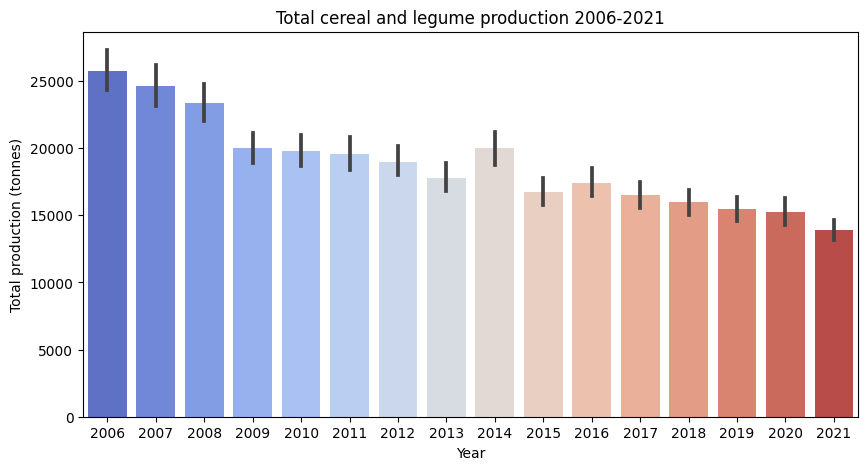

In [24]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'production_tonnes',data = cereals,palette='coolwarm')
plt.title('Total cereal and legume production 2006-2021')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Cereal production by Cities 

In [7]:
cereals_region = cereals.groupby(by = cereals.City)['production_tonnes','City'].sum().reset_index().sort_values(by = 'production_tonnes', ascending = False).head(10)
cereals_region

City  production_tonnes
32   Ferrara       195289702.00
13   Bologna       181246387.00
34    Foggia       155138543.00
85    Rovigo       141558559.00
65    Padova       137520502.00
68     Pavia       136706686.00
100  Treviso       129212018.00
51   Mantova       128989278.00
105  Venezia       127448605.00
96    Torino       124117980.00

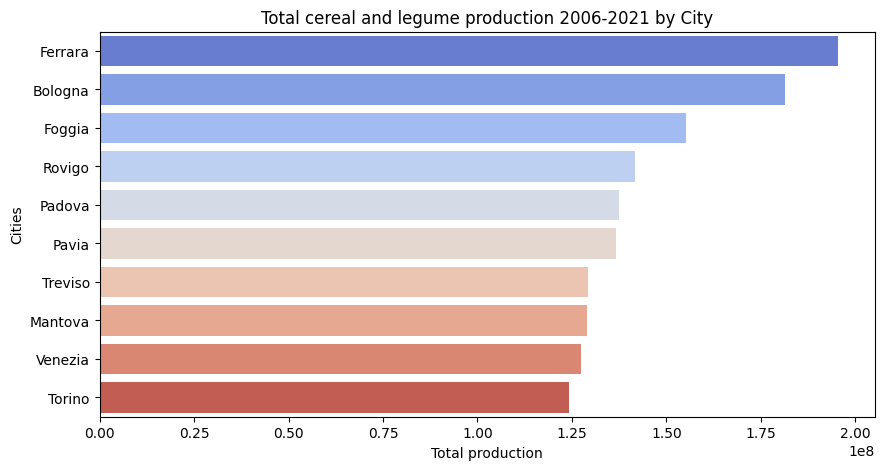

In [25]:
plt.figure(figsize= (10,5))
sns.barplot(x=cereals_region['production_tonnes'],y= cereals_region['City'], orient='h', palette='coolwarm');
plt.title('Total cereal and legume production 2006-2021 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

## Cereals highest production 2006-2022

In [9]:
print(cereals.Type_crop.max())
print(cereals.Type_crop.value_counts())
print(cereals.Type_crop.nunique())



winter cereal mixtures (maslin)
potatoes                                                           16831
barley                                                             16443
grain maize                                                        15770
oats                                                               15622
durum wheat                                                        15096
common wheat                                                       15050
sorghum                                                            12026
dried kidney bean                                                  11871
broad bean                                                         10953
other cereals                                                      10588
chick-peas                                                         10292
protein pea                                                         8983
rye                                                                 8537
grain pea          

Dataset shows there are 29 different types of cereals cultivated in Italy. Ten crop produced are Common wheat, Durum wheat, Potatoes, Barley, Maize, Beans, Chick-peas, Rye, Rice and Oats. 

In [10]:
cereals.describe().astype(int)

Year  production_tonnes  total_area_ha      PS      TS    QV2M  \
count  206851             206851         206851  206851  206851  206851   
mean     2013              18562           2853      94      13       7   
std         4              64215          10170      18       4       1   
min      2006                  0              0       0       0       0   
25%      2010                103             33      95      12       7   
50%      2014                892            181      98      14       7   
75%      2018               7440           1469      99      16       8   
max      2021            1016400         242000     101      20      10   

         RH2M    WS2M  GWETTOP  T2M_MAX  T2M_MIN  GWETPROF  GWETROOT  \
count  206851  206851   206851   206851   206851    206851    206851   
mean       70       2        0       24        4         0         0   
std        14       0        0        5        3         0         0   
min         0       0        0        0      -13         0         0   
25%        70       1        0       23        2         0         0   
50%        72       2        0       25        4         0         0   
75%        74       2        0       26        7         0         0   
max        84       4        0       30       14         0         0   

       CLOUD_AMT  T2M_RANGE  PRECTOTCORR  Fertilizers_tonnes     lat     lon  
count     206851     206851       206851              206851  206851  206851  
mean          50         19            2                1879      42      12  
std           11          5            0                4502       5       2  
min            0          0            0                   0       0       0  
25%           46         17            1                  37      40      10  
50%           52         20            2                 297      43      12  
75%           56         22            2                1474      45      14  
max           74         28            4               98671      46      18

In [11]:
# Rename name of crops 
cereals = cereals.replace('oats and spring cereal mixtures (mixed grain other than maslin)','oats mix')
cereals = cereals.replace('rye and winter cereal mixtures (maslin)','rye mix')
cereals = cereals.replace('spring cereal mixtures (mixed grain other than maslin)','cereal mix')
cereals = cereals.replace('common spring wheat and spelt','c-spr-wheat&spelt')
cereals = cereals.replace('common winter wheat and spelt','c-wint-wheat&spelt')
cereals = cereals.replace('winter cereal mixtures (maslin)','wint-cereal-mix')
cereals = cereals.replace('dried kidney bean','dry-k-bean')
cereals = cereals.replace('common wheat','c-wheat')
cereals = cereals.replace('durum wheat','d-wheat')
cereals = cereals.replace('broad bean','bro-bean')
cereals = cereals.replace('grain maize','maize')



 

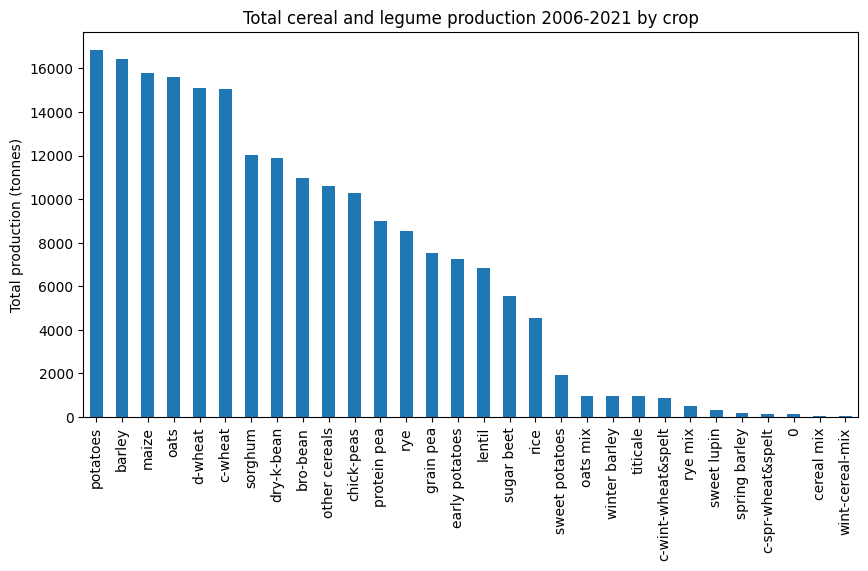

In [26]:
plt.figure(figsize=(10,5))
cereals['Type_crop'].value_counts().plot.bar()
plt.title('Total cereal and legume production 2006-2021 by crop')
plt.ylabel('Total production (tonnes)')
plt.show()


## Subseting data

In [13]:
cereals_top10 = cereals.apply(lambda row: row[cereals['Type_crop'].isin(['barley','oats', 
                                         'd-wheat','c-wheat', 'maize', 'potatoes','dry-k-bean',
                                          'bro-bean','chick-peas','rye'])])

cereals_top10.head()

City Type_crop  Year  production_tonnes  total_area_ha    PS    TS  \
0  Agrigento    barley  2006             897.00         345.00 96.87 16.70   
1  Agrigento    barley  2006             897.00         345.00 96.87 16.70   
2  Agrigento    barley  2006             897.00         345.00 96.87 16.70   
3  Agrigento    barley  2006             897.00         345.00 96.87 16.70   
4  Agrigento    barley  2006             897.00         345.00 96.87 16.70   

   QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  T2M_RANGE  \
0  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
1  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
2  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
3  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
4  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   

   PRECTOTCORR     Type_fertilizer  Fertilizers_tonnes   lat   lon  
0         1.58   calcium cyanamide                0.00 37.31 13.58  
1         1.58  nitrogen-potassium               27.70 37.31 13.58  
2         1.58         peaty-amend              174.50 37.31 13.58  
3         1.58    organic-nitrogen              760.50 37.31 13.58  
4         1.58             organic             1343.70 37.31 13.58  

[5 rows x 22 columns]

In [27]:
cereals_top10.total_area_ha.unique()

array([  345.,  3710.,   125., ..., 15215.,  3008., 16516.])

In [29]:
Q1 = cereals_top10.quantile(0.25)
Q3 = cereals_top10.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

production_tonnes    11095.00
total_area_ha         2442.00
PS                       3.79
TS                       4.14
QV2M                     1.29
RH2M                     4.02
WS2M                     1.15
GWETTOP                  0.13
T2M_MAX                  3.18
T2M_MIN                  4.93
GWETPROF                 0.11
GWETROOT                 0.11
CLOUD_AMT               10.22
T2M_RANGE                4.60
PRECTOTCORR              0.82
Fertilizers_tonnes    1348.10
lat                      4.25
lon                      4.18
dtype: float64


In [30]:
# Remove outliers
cereals_top10 = cereals_top10[~((cereals_top10 < (Q1 - 1.5 * IQR)) | (cereals_top10 > (Q3 + 1.5 * IQR))).any(axis=1)]
print(cereals_top10.shape)


(87987, 22)


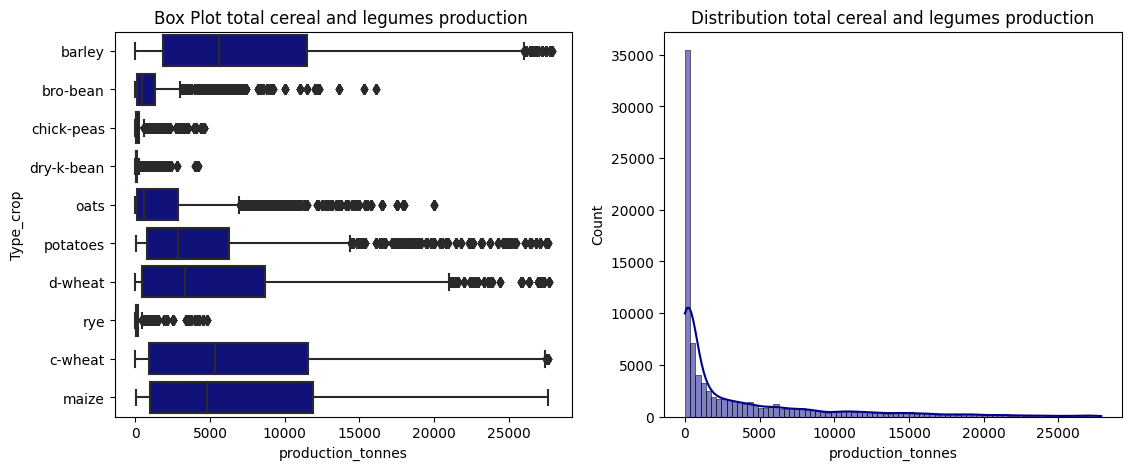

In [31]:
#Box plot and histplot (crop production distribuition)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.boxplot(data=cereals_top10, x='production_tonnes', y="Type_crop",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total cereal and legumes production ')

plt.subplot(1,2,2)
sns.histplot(data=cereals_top10, x= 'production_tonnes',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total cereal and legumes production')

plt.show()



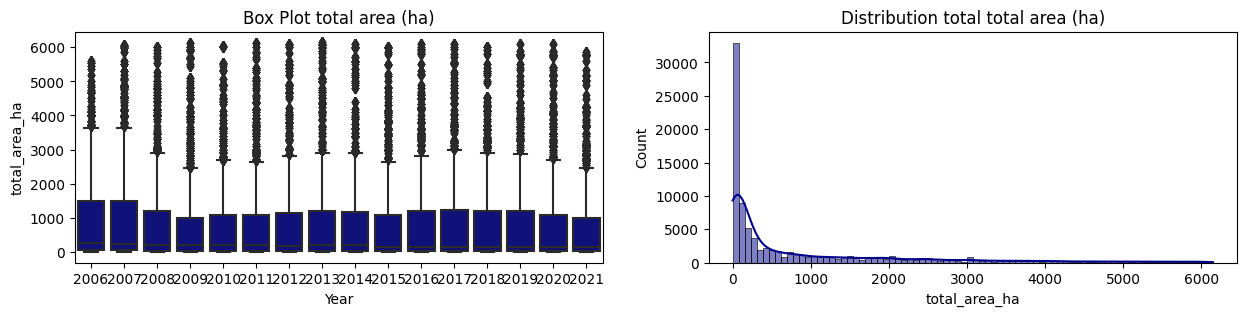

In [32]:
#Box plot and histplot of total area(ha)

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
sns.boxplot(data=cereals_top10, x='Year', y="total_area_ha",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total area (ha)')

plt.subplot(1,2,2)
sns.histplot(data=cereals_top10, x= 'total_area_ha',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total total area (ha)')

plt.show()



In [55]:
print(cereals_top10.total_area_ha.max())
print(cereals_top10.total_area_ha.min())
print(cereals_top10.total_area_ha.value_counts())
print(cereals_top10.total_area_ha.nunique())

6150.0
0.0


In [56]:
print(cereals_top10.Fertilizers_tonnes.max())


3405.0


<AxesSubplot: xlabel='Year', ylabel='Fertilizers_tonnes'>

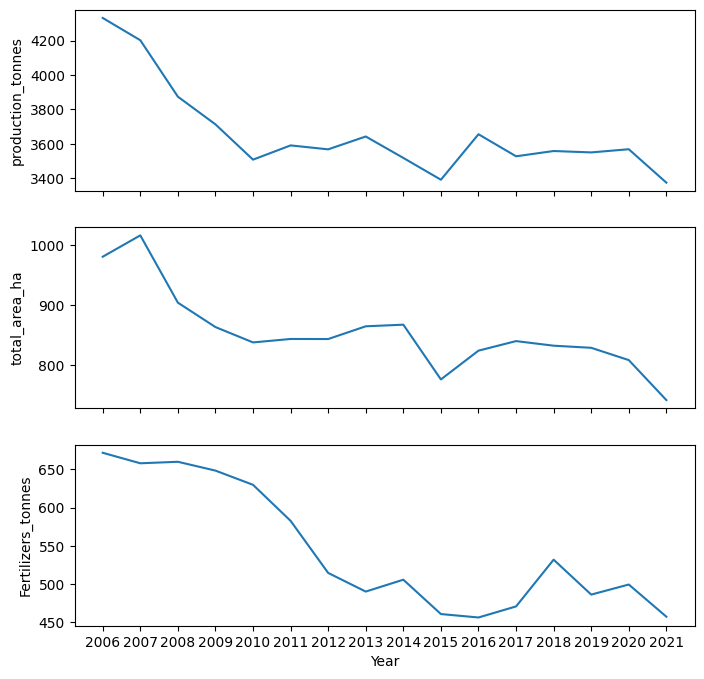

In [33]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,8))

cereals_top10['Year'] = (cereals_top10['Year']).astype(str)

# Total crop production
crops = cereals_top10[['Year', 'production_tonnes']]
crops = crops.groupby('Year').mean()
sns.lineplot(data= crops, x="Year", y="production_tonnes", ax=ax[0])

# Total area
crops = cereals_top10[['Year', 'total_area_ha']]
crops = crops.groupby('Year').mean()
sns.lineplot(data= crops, x="Year", y="total_area_ha", ax=ax[1])

# Ferlizers
fertilizers = cereals_top10[['Year', 'Fertilizers_tonnes']]
fertilizers = fertilizers.groupby('Year').mean()

sns.lineplot(data= fertilizers, x="Year", y="Fertilizers_tonnes", ax=ax[2])




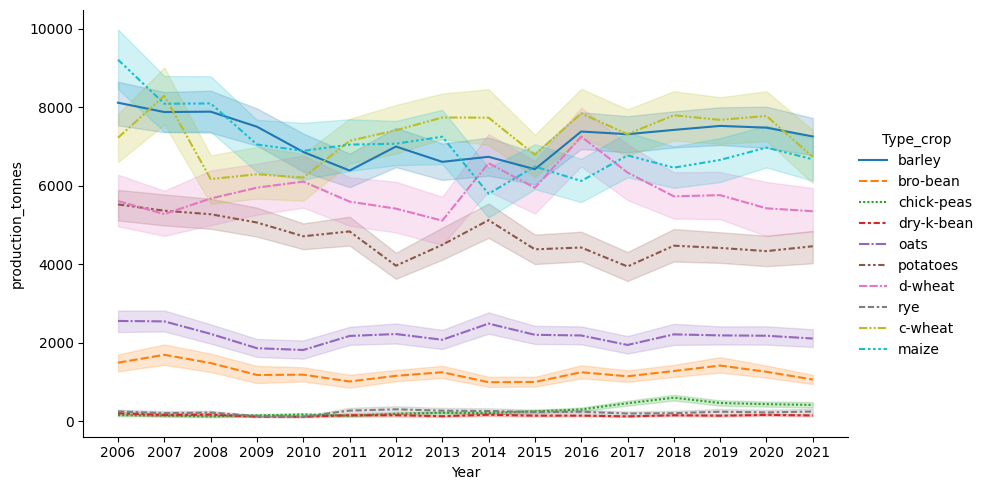

In [34]:
#Crop harvested by year

plotcrop10 = sns.relplot(kind='line', data=cereals_top10, x='Year', 
                         y='production_tonnes', hue='Type_crop', style='Type_crop', aspect=1.75)


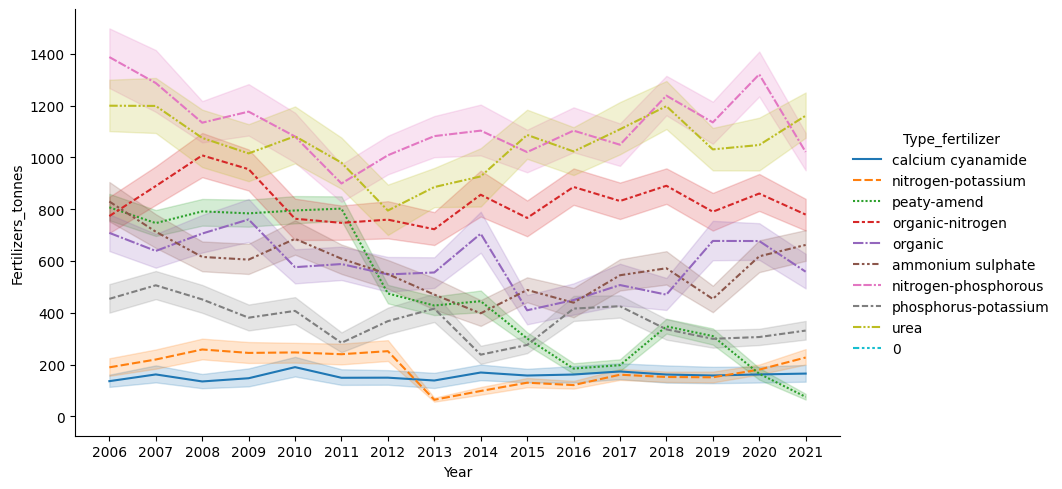

In [35]:
#Fertilizers distributed by year

plotfertilizers10 = sns.relplot(kind='line', data=cereals_top10, x='Year', 
                         y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)

# Climate data analysis

|Param_Code|Param_Name|Resolution|Depth [m]|Units|
|:--------:|:--------:|:--------:|:-------:|:---:|
|GWETPROF|Profile Soil Moisture|0.5° x 0.625°|1.34 - 8.53|water-free [0], saturated soil[1]| 
|GWETTOP|Surface Soil Wetness|0.5° x 0.625°|0.00 - 0.05| water-free [0], saturated soil[1]|
|GWETROOT|Root Zone Soil Wetness|0.5° x 0.625°|0.10 - 1.00|water-free [0], saturated soil[1]|
|CLOUD_AMT|Cloud Amount|---|---|%|
|TS|Earth Skin Temperature|---|---|°C|
|PS|Surface Pressure|---|---|kPa|
|RH2M|Relative Humidity at 2 Meters|---|---|%|
|QV2M|Specific Humidity at 2 Meters|---|---|g/kg|
|PRECTOTCORR|Precipitation Corrected|---|---|mm/day|
|T2M_MAX|Temperature at 2 Meters Maximum|---|---|°C|
|T2M_MIN|Temperature at 2 Meters Minimum|---|---|°C|
|T2M_RANGE|Temperature at 2 Meters Range|---|---|°C|
|WS2M|Wind Speed at 2 Meters|---|---|m/s|


  

*Precipitation Corrected (PRECTOTCORR)- [The bias corrected average of total precipitation at the surface of the earth in water mass (includes water content in snow)]

*Source? https://power.larc.nasa.gov/#resources

<AxesSubplot: xlabel='Year', ylabel='GWETROOT'>

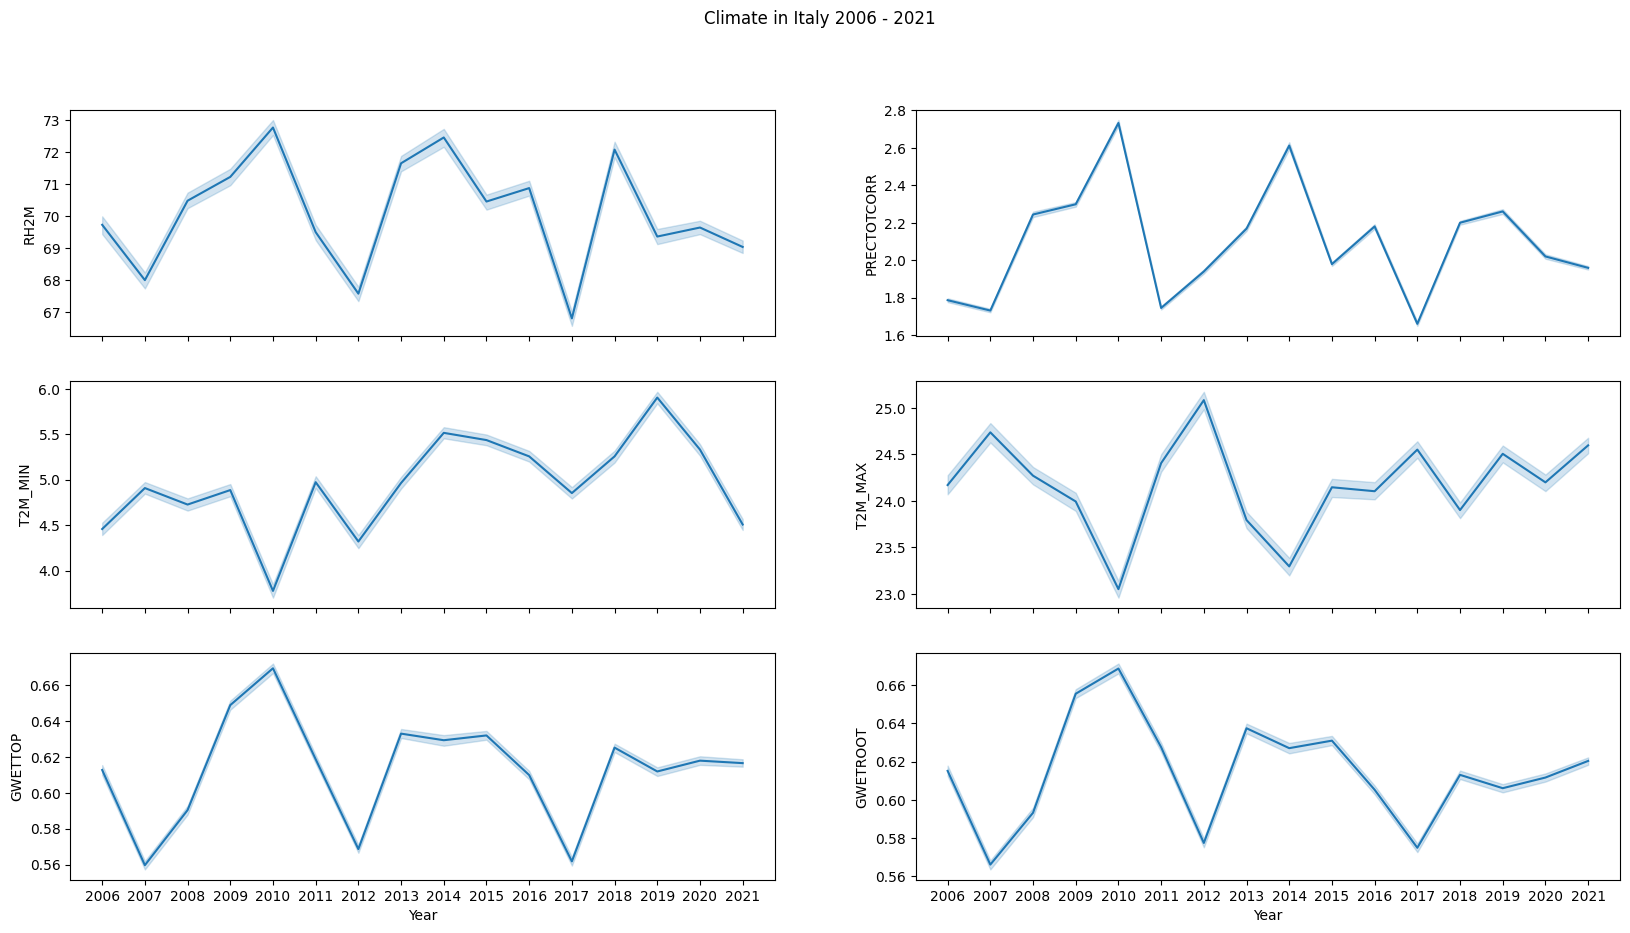

In [36]:

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(20,10))

fig.suptitle('Climate in Italy 2006 - 2021')

cereals['Year'] = (cereals['Year']).astype(str)

# relative_humidity
sns.lineplot(data= cereals, x="Year", y="RH2M", ax=ax[0,0])

# precipitation
sns.lineplot(data= cereals, x="Year", y="PRECTOTCORR", ax=ax[0,1])

# temp_max
sns.lineplot(data= cereals, x="Year", y="T2M_MIN", ax=ax[1,0])

# temp_min
sns.lineplot(data= cereals, x="Year", y="T2M_MAX", ax=ax[1,1])

# surface_soil_wetness
sns.lineplot(data= cereals, x="Year", y="GWETTOP", ax=ax[2,0])

# root_zone_wetness
sns.lineplot(data= cereals, x="Year", y="GWETROOT", ax=ax[2,1])


In [ ]:
cereals

In [37]:
cereals_model = cereals_top10.drop(columns =['Year','PS','TS','GWETTOP', 'QV2M','WS2M','T2M_RANGE','GWETPROF','CLOUD_AMT','PRECTOTCORR','lat', 'lon'  ])
cereals_model

City Type_crop  production_tonnes  total_area_ha  \
0                   Agrigento    barley             897.00         345.00   
1                   Agrigento    barley             897.00         345.00   
2                   Agrigento    barley             897.00         345.00   
3                   Agrigento    barley             897.00         345.00   
4                   Agrigento    barley             897.00         345.00   
...                       ...       ...                ...            ...   
206194  Monza e della Brianza       rye              24.50           7.00   
206195  Monza e della Brianza       rye              24.50           7.00   
206196  Monza e della Brianza       rye              24.50           7.00   
206197  Monza e della Brianza       rye              24.50           7.00   
206199  Monza e della Brianza       rye              24.50           7.00   

        RH2M  T2M_MAX  T2M_MIN  GWETROOT       Type_fertilizer  \
0      71.95    28.51     6.77      0.62     calcium cyanamide   
1      71.95    28.51     6.77      0.62    nitrogen-potassium   
2      71.95    28.51     6.77      0.62           peaty-amend   
3      71.95    28.51     6.77      0.62      organic-nitrogen   
4      71.95    28.51     6.77      0.62               organic   
...      ...      ...      ...       ...                   ...   
206194 72.07    24.09     3.30      0.71  phosphorus-potassium   
206195 72.07    24.09     3.30      0.71               organic   
206196 72.07    24.09     3.30      0.71                  urea   
206197 72.07    24.09     3.30      0.71      organic-nitrogen   
206199 72.07    24.09     3.30      0.71     calcium cyanamide   

        Fertilizers_tonnes  
0                     0.00  
1                    27.70  
2                   174.50  
3                   760.50  
4                  1343.70  
...                    ...  
206194               10.00  
206195               51.00  
206196             1421.00  
206197               17.00  
206199                0.00  

[87987 rows x 10 columns]

# Pre-processing data for modelling 

In [38]:
from pycaret.regression import *

In [39]:
regr = setup(data = cereals_model, target = 'production_tonnes', session_id = 123,
             categorical_features= ['City', 'Type_crop','Type_fertilizer'], normalize = True )

In [40]:
best = compare_models()

In [42]:
knn = create_model('knn')

# Tune model


In [43]:
tuned_knn = tune_model(knn)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


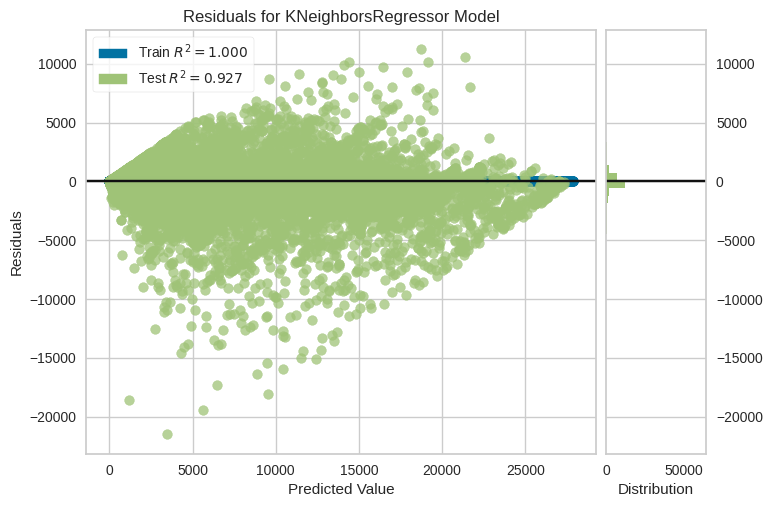

In [44]:
plot_model(tuned_knn) 

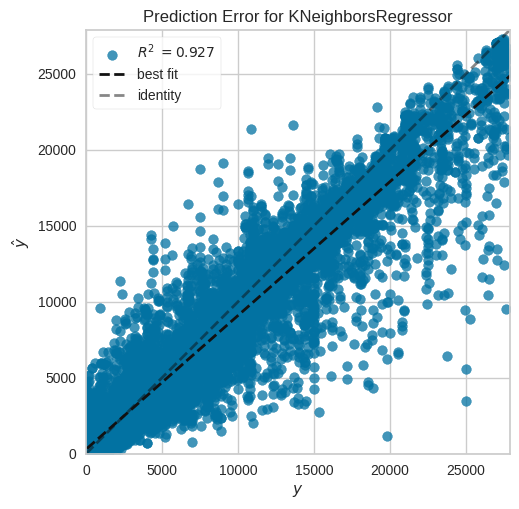

In [45]:
plot_model(tuned_knn, plot = 'error')


In [46]:
plot_model(tuned_knn, plot = 'parameter')


Parameters
algorithm           auto
leaf_size             30
metric         manhattan
metric_params       None
n_jobs                -1
n_neighbors           13
p                      2
weights         distance

# Predict Model

In [47]:
predictions = predict_model(tuned_knn)

In [48]:
final_knn = finalize_model(tuned_knn)

In [49]:
print(final_knn)


Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['total_area_ha', 'RH2M', 'T2M_MAX',
                                             'T2M_MIN', 'GWETROOT',
                                             'Fertilizers_tonnes'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['City', 'Type_crop',
                                             'Type_fertilizer'],
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strate...
                                    transformer=LeaveOneOutEncoder(cols=['City',
                                                                         'Type_crop',
                                                                         'Type_fertilizer'],
                                            

In [50]:
save_model(final_knn, 'cereals_knn')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['total_area_ha', 'RH2M', 'T2M_MAX',
                                              'T2M_MIN', 'GWETROOT',
                                              'Fertilizers_tonnes'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['City', 'Type_crop',
                                              'Type_fertilizer'],
                                     transformer=SimpleImputer(fill_value='constant',
                                                               strate...
                                     transformer=LeaveOneOutEncoder(cols=['City',
                                                                          'Type_crop',
                                                                          'Type_fertilizer'],
                              

In [51]:
new_data = cereals_model.copy()
new_data.drop(['production_tonnes'], axis=1, inplace=True)
predict_new = predict_model(final_knn, data=new_data)
predict_new.head()


City  Type_crop  total_area_ha  RH2M  T2M_MAX  T2M_MIN  GWETROOT  \
0 -0.32       1.25          -0.39 -0.28     1.51     0.34     -0.10   
1 -0.32       1.25          -0.39 -0.28     1.51     0.34     -0.10   
2 -0.32       1.25          -0.39 -0.28     1.51     0.34     -0.10   
3 -0.32       1.25          -0.39 -0.28     1.51     0.34     -0.10   
4 -0.32       1.25          -0.39 -0.28     1.51     0.34     -0.10   

   Type_fertilizer  Fertilizers_tonnes  prediction_label  
0             0.46               -0.70            912.50  
1             0.45               -0.66            896.68  
2             0.28               -0.47            896.78  
3             0.46                0.29            917.60  
4             0.13                1.04            952.32

In [52]:
new_data.Type_crop.unique()

array(['barley', 'bro-bean', 'chick-peas', 'dry-k-bean', 'oats',
       'potatoes', 'd-wheat', 'rye', 'c-wheat', 'maize'], dtype=object)

In [53]:
new_data.City.unique()

array(['Agrigento', 'Alessandria', 'Ancona', 'Arezzo', 'Ascoli Piceno',
       'Asti', 'Avellino', 'Bari', 'Belluno', 'Benevento', 'Bergamo',
       'Biella', 'Bologna', 'Brescia', 'Brindisi', 'Caltanissetta',
       'Campobasso', 'Caserta', 'Catania', 'Catanzaro', 'Chieti', 'Como',
       'Cosenza', 'Cremona', 'Crotone', 'Cuneo', 'Enna', 'Ferrara',
       'Firenze', 'Foggia', 'Frosinone', 'Genova', 'Gorizia', 'Grosseto',
       'Imperia', 'Isernia', 'La Spezia', 'Latina', 'Lecce', 'Lecco',
       'Livorno', 'Lodi', 'Lucca', 'Macerata', 'Mantova', 'Matera',
       'Messina', 'Milano', 'Modena', 'Napoli', 'Novara', 'Nuoro',
       'Oristano', 'Padova', 'Palermo', 'Parma', 'Pavia', 'Perugia',
       'Pesaro e Urbino', 'Pescara', 'Piacenza', 'Pisa', 'Pistoia',
       'Pordenone', 'Potenza', 'Prato', 'Ragusa', 'Ravenna',
       'Reggio di Calabria', "Reggio nell'Emilia", 'Rieti', 'Rimini',
       'Roma', 'Rovigo', 'Salerno', 'Sassari', 'Savona', 'Siena',
       'Siracusa', 'Taranto', 'Tera

In [54]:
new_data.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrogen-potassium', 'peaty-amend',
       'organic-nitrogen', 'organic', 'ammonium sulphate',
       'nitrogen-phosphorous', 'phosphorus-potassium', 'urea', '0'],
      dtype=object)

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html

https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

https://lost-stats.github.io/Presentation/Figures/heatmap_colored_correlation_matrix.html

https://plotly.com/python/box-plots/

https://pycaret.org/